In [53]:
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

In [54]:
df = pd.read_csv('../debate_dataset.csv')
df.head()

,comment_id,post_id,debate_group,comment_user_name,commented_user_name,comment_body,comment_score
0,ki3k2mh,197vo6o,1,SurprysE,Odd_Sentence_2618,BOIA SI! Basta guardare da dove sono registrat...,11
1,ki5i0gd,197vo6o,1,SurprysE,the_white_cloud,"Non fa una grinza, ma metti in movimento il tu...",1
2,ki4y2a5,197vo6o,1,SurprysE,the_white_cloud,Sono bot che fanno un minimo di attività per e...,1
3,ki3r883,197vo6o,1,theseawillclaim,zombilives,"Ma immagino, anche il suo brand è sempre in ro...",12
4,ki3jhkw,197vo6o,2,Polaroid1793,TURBINEFABRIK74,Non ho mai visto una persona in vita mia camb...,3


In [55]:
post_id_dict = {}
dataframe_list = []
for post_id in df['post_id'].unique():
    dataframe = df[df['post_id'] == post_id]
    dataframe_list.append(dataframe)
    post_id_dict[post_id] = dataframe

In [56]:
def create_graph_from_dataframe(dataframe):
    graph = ig.Graph(directed=True)
    graph.add_vertex(name='root', label='root')
    for comment in dataframe.iterrows():
        if comment[1]['comment_user_name'] not in graph.vs['name']:
            graph.add_vertex(name=comment[1]['comment_user_name'], label=comment[1]['comment_user_name'])
        if comment[1]['commented_user_name'] not in graph.vs['name']:
            graph.add_vertex(name=comment[1]['commented_user_name'], label=comment[1]['commented_user_name'])
        graph.add_edge(comment[1]['comment_user_name'], comment[1]['commented_user_name'])
    
    graph.delete_vertices('root')
    return graph

post_id_graph = {}
for dataframe in dataframe_list:
    graph = create_graph_from_dataframe(dataframe)
    post_id_graph[dataframe['post_id'].iloc[0]] = graph

# Metriche di valutazione dei grafi di dibattitio

## Metriche sul POST

### Calcolo dell' average degree
Calcolando l'average degree di ciascun post, è possibile farsi un'idea generale di quanto gli utenti tendono ad interagire tra di loro 

In [57]:
def degree_distribution(graph):
    degree = graph.degree()
    n = graph.vcount()
    degree = np.array(degree)

    return 1/n * sum(degree)

### Distribuzione dei gradi
Questo grafico ci permette di osservare la distribuzione dei gradi di ogni nodo all'interno del grafo, offrendo una visione chiara del livello di interazione degli utenti. **Qual è la percentuale di utenti che hanno interagito poco/tanto con il post?**

In [58]:
def compute_degree_distribution(graph):
    degree = graph.degree()
    x = np.unique(degree)
    degree = np.array(degree)
    y = []
    for i in x:
        y.append(sum(degree == i)/ len(degree)) 
    return x, y

Post:197vo6o as average degree of 6.125
Post:19aeo2k as average degree of 6.909090909090909
Post:1b6cg4q as average degree of 9.555555555555555
Post:1cwqkqe as average degree of 10.058823529411764
Post:1bulhj9 as average degree of 10.185567010309278
Post:1d5h5h6 as average degree of 8.779220779220779
Post:17z2hci as average degree of 11.326315789473684
Post:17lese9 as average degree of 10.13953488372093
Post:10v8sey as average degree of 9.85858585858586
Post:post_id as average degree of 1.0


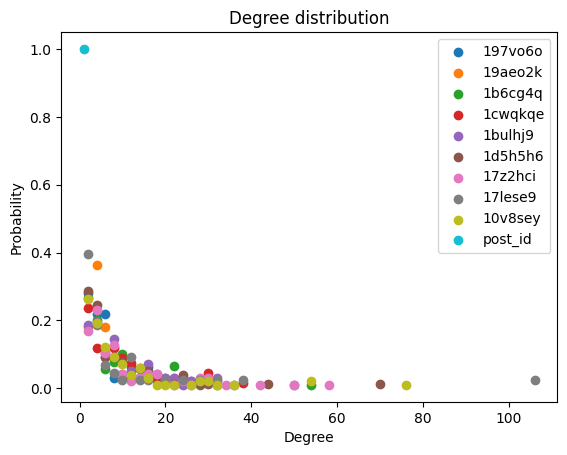

In [59]:
for post_graph in post_id_graph:
    print(f'Post:{post_graph} as average degree of {degree_distribution(post_id_graph[post_graph])}')
    x, y = compute_degree_distribution(post_id_graph[post_graph])
    plt.scatter(x, y)
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.title('Degree distribution')

plt.legend(post_id_graph.keys())
plt.show()

## Metriche sul Dibattito

### Coefficiente di clustering medio
Tramite il coefficiente di clustring medio possiamo ottenere una misura golbale del grado di coesione degli utenti all'interno della dibattito, ovvero quanto gli utenti hanno interagito tra di loro all'interno della discussione in questione.

In [60]:
def compute_average_clustering_coefficient(graph):
    clustering_medio = graph.transitivity_avglocal_undirected()
    if clustering_medio != clustering_medio:
        clustering_medio = 0.0
    
    return clustering_medio

In [61]:
for post_df in post_id_dict.values():
    post_id = post_df['post_id'].iloc[0]
    for debate_id in post_df['debate_group'].unique():
        if debate_id != '0':
            debate_df = post_df[post_df['debate_group'] == debate_id]
            graph = create_graph_from_dataframe(debate_df)

In [63]:
def compute_debate_relevance(debate, graph):
    n_graph_nodes = graph.vcount()
    n_graph_edges = graph.ecount()
    n_nodes = debate.vcount()/n_graph_nodes
    n_edges = debate.ecount()/n_graph_edges
    avg_degree = degree_distribution(debate)
    clustering_coefficient = compute_average_clustering_coefficient(debate)
    return n_nodes + n_edges + avg_degree + clustering_coefficient

for post_df in post_id_dict.values():
    post_id = post_df['post_id'].iloc[0]
    for debate_id in post_df['debate_group'].unique():
        if debate_id != '0':
            debate_df = post_df[post_df['debate_group'] == debate_id]
            debate_graph = create_graph_from_dataframe(debate_df)
            n_nodes, n_edges, avg_degree, clustering_coefficient = compute_debate_relevance(debate_graph, graph)
            print(f'Post:{post_id} Debate:{debate_id} n_nodes:{n_nodes} n_edges:{n_edges} avg_degree:{avg_degree} clustering_coefficient:{clustering_coefficient}')

Post:197vo6o Debate:1 n_nodes:1.0 n_edges:1.0 avg_degree:3.176470588235294 clustering_coefficient:0.0
Post:197vo6o Debate:2 n_nodes:0.11764705882352941 n_edges:0.1111111111111111 avg_degree:3.0 clustering_coefficient:0.0
Post:197vo6o Debate:3 n_nodes:0.17647058823529413 n_edges:0.1111111111111111 avg_degree:2.0 clustering_coefficient:0.0
Post:197vo6o Debate:4 n_nodes:0.6470588235294118 n_edges:0.5925925925925926 avg_degree:2.909090909090909 clustering_coefficient:0.0
Post:197vo6o Debate:7 n_nodes:1.0 n_edges:1.0 avg_degree:3.176470588235294 clustering_coefficient:0.0
Post:197vo6o Debate:8 n_nodes:0.11764705882352941 n_edges:0.1111111111111111 avg_degree:3.0 clustering_coefficient:0.0
Post:197vo6o Debate:9 n_nodes:0.17647058823529413 n_edges:0.1111111111111111 avg_degree:2.0 clustering_coefficient:0.0
Post:197vo6o Debate:5 n_nodes:0.6470588235294118 n_edges:0.5925925925925926 avg_degree:2.909090909090909 clustering_coefficient:0.0
Post:19aeo2k Debate:5 n_nodes:0.35294117647058826 n_edge